---
layout: single
title: 'Coloring lidar point clouds with RGB imagery in R'
date: 2016-07-01
authors: [Max Joseph]
category: [tutorials]
excerpt: 'This tutorial shows how to color lidar point clouds with RGB imagery, using freely available data from the National Ecological Observatory Network (NEON).'
sidebar:
  nav:
author_profile: false
comments: true
lang: [r]
lib: [rLiDAR, raster, scatterplot3d, scales]
---

Discrete lidar point clouds provide measurements of surface topography (e.g., Easting, Northing, and altitude), but these 3d point clouds are easier to visualize when the points are colored. From a georeferenced RGB image, you can extract colors at the locations of each point and produce a colored point cloud. Here, we will use some sample data provided by the National Ecological Observatory Network Airborne Observation Platform (NEON AOP), available [here](http://www.neonscience.org/data-resources/get-data/airborne-data). 

## Objectives

- acquire a lidar point cloud and georeferenced RGB imagery
- color points based on RGB images

## Dependencies

### R packages

- rLiDAR
- raster
- scatterplot3d
- scales

### Command line utilities

- wget
- unzip

In [1]:
library(rLiDAR)
library(scatterplot3d)
library(raster)
library(scales)
options(jupyter.plot_mimetypes = 'image/png')

# download data if necessary
dir_pattern <- "NEON_AOP_sample_data"
if (0 == length(dir(pattern = dir_pattern))) {
    download.file("http://neonhighered.org/AOPSampleData/AOP_sample_data.zip", 
                 destfile = "AOP_sample_data.zip")
    unzip("AOP_sample_data.zip")
}
neon_dir <- dir(pattern = dir_pattern)


Loading required package: sp


# Load lidar and RGB image data

The lidar data are loaded as a matrix with columns for x, y, and z coordinates.

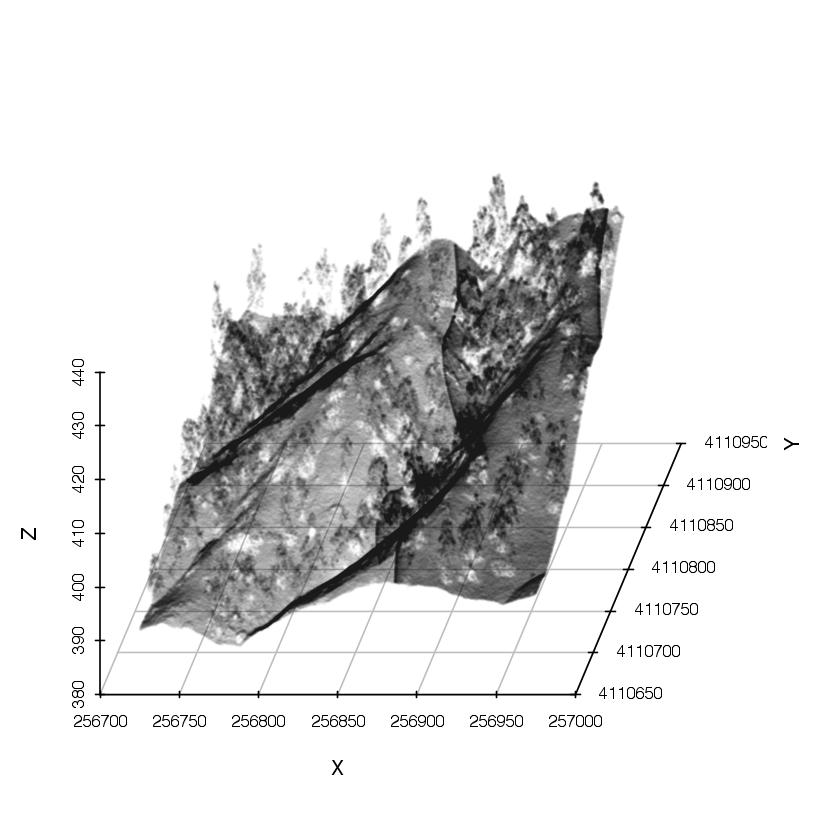

In [2]:
gen_lidar_path <- function(neon_dir) {
  lidar_dir <- 'LiDAR'
  type <- 'Discrete_LiDAR'
  which_lidar <- 'Point_Cloud'
  filename <- '2013_SJER_AOP_point_cloud_unclassified.las'
  file.path(neon_dir, lidar_dir, type, which_lidar, filename)
}

path_to_lidar <- gen_lidar_path(neon_dir)
lidar_d <- readLAS(path_to_lidar)
scatterplot3d(lidar_d[, 1:3], 
              cex.symbols = .1,
              pch = 19, 
              color = alpha(1, .02), 
              angle = 70, 
              box = FALSE)

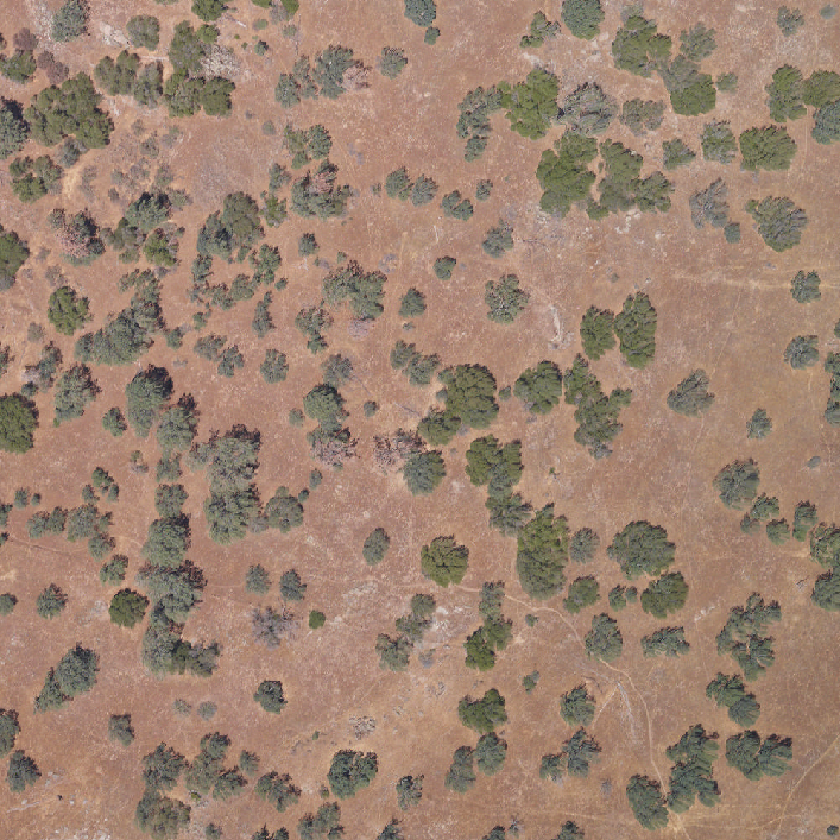

In [3]:
gen_rgb_path <- function(neon_dir) {
  rgb_dir <- 'RGB_Camera'
  filename <- '2013_SJER_AOP_Camera_sample.tif'
  file.path(neon_dir, rgb_dir, filename)
}

path_to_rgb <- gen_rgb_path(neon_dir)
rgb_image <- stack(path_to_rgb)
plotRGB(rgb_image)

# Combine lidar with RGB imagery

To link the lidar data to the RGB image, the coordinate systems must match (this requirement is satisfied in the NEON data).
First we extract color information for each point. 

In [4]:
# what color should each point be?
rgb_vals <- extract(rgb_image, lidar_d[, c('X', 'Y')])
color_vector <- rgb(red = rgb_vals[, 1], 
                    green = rgb_vals[, 2], 
                    blue = rgb_vals[, 3], 
                    maxColorValue = 255)

It may be better to plot the points in a space with no distortion. The function below will help rescale the axes in our final plot. 

In [5]:
scale_lims <- function(mat, column) {
    # get rescaled limits s.t. range = max range among x, y, and z
    #  - assumes columns 1:3 are x, y, and z in mat
    get_range <- function(x) {
      r_x <- range(x)
      r_x[2] - r_x[1]
    }

    column_ranges <- apply(mat[, 1:3], 2, get_range)
    max_range <- max(column_ranges)
    min_val <- min(mat[, column])
    c(min_val, min_val + max_range)
}

Now, rescaling our axes:

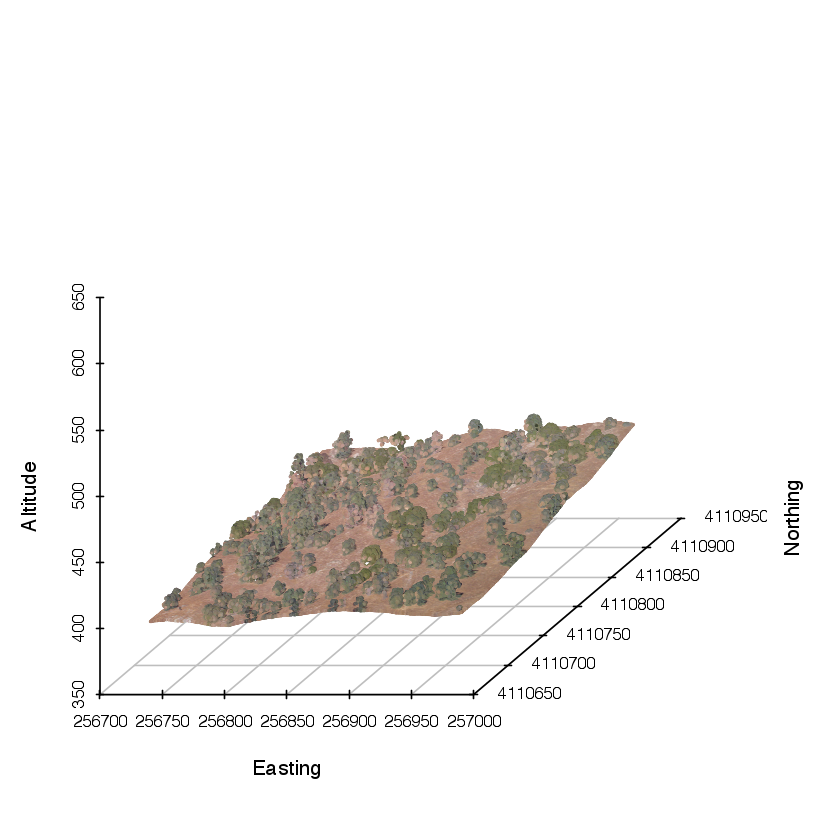

In [6]:
scatterplot3d(lidar_d[, 1:3], 
              color = color_vector, 
              cex.symbols = .01,
              pch = 19,
              xlim = scale_lims(lidar_d, 'X'), 
              ylim = scale_lims(lidar_d, 'Y'), 
              zlim = scale_lims(lidar_d, 'Z'), 
              box = FALSE, 
              xlab = 'Easting', 
              ylab = 'Northing', 
              zlab = 'Altitude')

For interactive visualizations, see `rgl::plot3d` and `threejs::scatterplot3js`.